In [1]:
from datetime import datetime
import ujson as json
import os
import sys

from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
from scipy.stats import shapiro, ttest_ind
from statsmodels.stats.weightstats import ztest

sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))

from eventdt import twitter
from multiplex import drawable

event = '#LIVATM' # available #CRYCHE, #SOUARS, #TURITA, #LIVATM
original = os.path.expanduser(f"~/DATA/c5-evaluation/{ event }/event.json")
downloaded = os.path.expanduser(f"~/DATA/c5-evaluation/{ event }/downloaded.json")
downloaded = os.path.expanduser(f"~/DATA/c5-evaluation/{ event }/ids-20211110.csv")

In [2]:
%%time
with open(downloaded, 'r') as dl:
    if downloaded.endswith('.csv'):
        ids = [ tid.strip() for tid in dl ]
    elif downloaded.endswith('.json'):
        ids = [ json.loads(tweet)['id_str'] for tweet in dl ] # downloaded tweets

CPU times: user 12.2 ms, sys: 146 µs, total: 12.4 ms
Wall time: 11.3 ms


In [3]:
%%time
data = { }
with open(original, 'r') as og:
    for i, tweet in enumerate(og):
        tweet = json.loads(tweet)
        text = twitter.full_text(tweet)
        id_str = tweet['id_str']
        available = id_str in ids

        # user features
        screen_name = tweet['user']['screen_name']
        friends_count = int(tweet['user']['friends_count'])
        followers_count = int(tweet['user']['followers_count'])
        has_followers = followers_count > 0
        favourites_count = int(tweet['user']['favourites_count'])
        description = len(tweet['user']['description']) if tweet['user']['description'] else 0
        has_description = description > 0
        statuses_count = int(tweet['user']['statuses_count'])
        verified = tweet['user']['verified']
        # the age is in days
        age = (twitter.extract_timestamp(tweet) - parse(tweet['user']['created_at']).timestamp()) / 60 / 60 / 24
        is_new = age <= 7
        
        # data features
        timestamp = twitter.extract_timestamp(tweet)
        hashtags = len(tweet['entities']['hashtags'])
        urls = len(tweet['entities']['urls'])
        has_urls = urls > 0
        mentions = len(tweet['entities']['user_mentions'])
        is_retweet = twitter.is_retweet(tweet)
        is_quote = twitter.is_quote(tweet)
        
        data[i] = { 'id': id_str, 'available': available, 'timestamp': timestamp, 'screen_name': screen_name,
                   
                    'friends_count': friends_count, 'followers_count': followers_count, 'has_followers': has_followers,
                    'favourites_count': favourites_count, 'statuses_count': statuses_count,
                    'age': age, 'is_new': is_new, 'description': description, 'has_description': has_description,
                    'verified': verified,
                  
                    'hashtags': hashtags, 'urls': urls, 'has_url': has_urls, 'mentions': mentions,
                    'is_retweet': is_retweet, 'is_quote': is_quote,
                  
                    'text': text }
        if i and not (i % 10000):
            print(f"{ i } tweets read")

df = pd.DataFrame.from_dict(data, "index")
df['has_stream'] = df.text.apply(lambda _text: 'stream' in _text.lower() )
df

10000 tweets read
20000 tweets read
30000 tweets read
40000 tweets read
50000 tweets read
60000 tweets read
70000 tweets read
80000 tweets read
90000 tweets read
100000 tweets read
CPU times: user 1min 18s, sys: 435 ms, total: 1min 19s
Wall time: 1min 19s


,id,available,timestamp,screen_name,friends_count,followers_count,has_followers,favourites_count,statuses_count,age,...,has_description,verified,hashtags,urls,has_url,mentions,is_retweet,is_quote,text,has_stream
0,1455984356821020679,True,1.635969e+09,reds4us,105,5487,True,145,140155,4470.797778,...,True,False,0,0,False,1,True,False,Milan and Porto finishes 1-1 at San Siro.\n\nW...,False
1,1455984357118812160,False,1.635969e+09,Lord_Taki_J,858,686,True,5912,59725,4457.318808,...,True,False,0,0,False,1,True,False,AC Milan have drew 1-1 with Porto tonight in t...,False
2,1455984358204985344,True,1.635969e+09,AshleyGHATER,6,0,False,8,17,4018.178762,...,True,False,0,1,True,1,False,True,It's time to Watch UCL:: PSG VS RB Leipzig Liv...,True
3,1455984359131987970,True,1.635969e+09,UTD_Lelon,964,595,True,20756,2325,126.872963,...,True,False,0,0,False,0,False,False,I actually don't know what to watch tonight.\n...,False
4,1455984359773769736,False,1.635969e+09,chooseleticiam,35,7,True,6,182,4126.847917,...,True,False,1,1,True,1,True,False,live broadcast Liverpool vs Atletico Madrid\n\...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107602,1456018327994658821,True,1.635977e+09,Samatoz2,829,153,True,134132,15071,2903.108056,...,True,False,0,0,False,1,True,False,THAT'S WHAT MANE DOES!!! https://t.co/wMAQW4tjlR,False
107603,1456018328619831296,True,1.635977e+09,PeterFitz2113,243,31,True,1165,284,557.307604,...,True,False,3,0,False,0,False,True,"Some teams celebrate wins, other celebrate dra...",False
107604,1456018328623923200,True,1.635977e+09,denwhitelam,1396,895,True,134530,57452,2559.270637,...,True,False,2,0,False,1,True,False,Lovely #LIVATM\n#YNWA https://t.co/gyQdDr7B5O,False
107605,1456018328884064266,True,1.635977e+09,JackBAFC,1381,1088,True,88312,26814,1886.551609,...,True,False,0,0,False,0,False,True,oh my god,False


Duplicate messages are a (remote) possibility as noted in [Twitter's API documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/integrate/consuming-streaming-data).
In fact, there are may be duplicates in the original datasets and in the downloaded datasets.

However, the duplicate tweets are small enough not to skew results.

In [4]:
# %%time

assert (i + 1) == len(df) # read all tweets
assert set(ids) == set(df[df.available].id.tolist()) # all downloaded IDs are in the DF
# assert all( _id in df.id.tolist() for _id in ids ) # takes long to execute
print("> Dataframe (contains all original tweets)")
print(f"Duplicates: { len(df[df.duplicated()]) }")
print(f"Duplicates (available): { len(df[df.duplicated() & df.available]) }")
print()
print("> Original dataset's tweets")
print(f"Tweets marked as available: { len(df[df.available].id) }")
print(f"Unique tweets marked as available: { len(set(df[df.available].id)) }")
print()
print("> Downloaded dataset's tweets")
print(f"Duplicates: { len(ids) - len(set(ids)) }")
print(f"Tweets downloaded: { len(ids) }")
print(f"Unique tweets downloaded: { len(set(ids)) }")

> Dataframe (contains all original tweets)
Duplicates: 1
Duplicates (available): 1

> Original dataset's tweets
Tweets marked as available: 91620
Unique tweets marked as available: 91619

> Downloaded dataset's tweets
Duplicates: 0
Tweets downloaded: 91619
Unique tweets downloaded: 91619


In [5]:
df[~df.available].sample(10)
# print(df[df.id == '1456001178609848323'].iloc[0].available,
#       df[df.id == '1456001178609848323'].iloc[0].text)
# print()
# print(df[df.id == '1456000218911096845'].iloc[0].available,
#       df[df.id == '1456000218911096845'].iloc[0].text)

,id,available,timestamp,screen_name,friends_count,followers_count,has_followers,favourites_count,statuses_count,age,...,has_description,verified,hashtags,urls,has_url,mentions,is_retweet,is_quote,text,has_stream
7683,1455987855000580100,False,1.635970e+09,MaaxiAngelo,874,22373,True,30682,50284,2631.941007,...,True,False,0,1,True,0,False,False,Can’t believe Liverpool’s assistant manager Pe...,False
103431,1456017380639973379,False,1.635977e+09,bmkbrunner,52928,49012,True,158551,33850,2434.644954,...,True,False,5,0,False,2,True,False,@LFC unbeaten in all Leagues 🤩\n2021/2022 #UCL...,False
97362,1456015078441033728,False,1.635976e+09,passionaate_,1102,10346,True,72906,72483,2105.201505,...,True,False,1,0,False,1,True,False,Oxlade down injured. Minamino coming on #LFC,False
79213,1456006493497667586,False,1.635974e+09,Sue974,0,0,False,23,38,3170.010208,...,True,False,1,1,True,1,True,False,LIVE STREAM\nLive Streaming Link\n\nLive ​LINK...,True
28089,1455994115515043841,False,1.635971e+09,AlyGholam,1132,5074,True,117022,129328,3838.161447,...,True,False,0,0,False,1,True,False,Liverpool are absolutely on one 😤,False
73436,1456004903017517060,False,1.635974e+09,GetHugsNotDrugs,75,481,True,56,1795,3384.670683,...,True,False,1,1,True,1,True,False,Live Stream HD. \n\nLiverpool vs atletico\n\nM...,True
4299,1455986818843807745,False,1.635969e+09,JakeDCurtis1,1001,115,True,565,335,1919.996667,...,True,False,1,0,False,0,False,False,Can’t wait to watch Liverpool get torn a new a...,False
52601,1455999631154950144,False,1.635972e+09,MulvanyAvril,320,309,True,11925,2470,538.790486,...,True,False,1,0,False,0,False,False,Take the L Simeone literally 😁 #lfc 🙌🏼❤️⚽️ htt...,False
79052,1456006441890983937,False,1.635974e+09,kinendiaye1225,604,437,True,4219,8941,484.131146,...,True,False,0,0,False,0,False,False,Liverpool me rend heureuse 😭❤️,False
1820,1455985595642228749,False,1.635969e+09,juliacinemylife,113,33,True,11,55,2636.744340,...,True,False,2,1,True,1,True,False,Watch live streaming #UCL\n\nLiverpool vs Atl...,True


In [6]:
df[df.available].sample(10)

,id,available,timestamp,screen_name,friends_count,followers_count,has_followers,favourites_count,statuses_count,age,...,has_description,verified,hashtags,urls,has_url,mentions,is_retweet,is_quote,text,has_stream
75687,1456005418883420164,True,1.635974e+09,_messichiquito,17,6,True,185,1582,230.947280,...,True,False,0,0,False,1,False,False,@Atleti small club,False
103239,1456017340974444544,True,1.635977e+09,oldschoolitems1,2284,1622,True,48453,49897,1102.210035,...,True,False,0,0,False,1,True,False,FT: Liverpool 2-0 Atletico Madrid\n\nLiverpool...,False
105322,1456017810409263104,True,1.635977e+09,MerciWenger,1486,5772,True,32230,2986,2785.701192,...,True,False,0,1,True,0,False,False,"Liverpool pumping Atleti, home &amp; away is n...",False
46463,1455998335005888513,True,1.635972e+09,AnnalNagel,367,496,True,252816,191745,3390.344907,...,True,False,0,0,False,1,True,False,2-0 down and Atleti have decided to stop kicki...,False
82125,1456007376654458893,True,1.635974e+09,SaltySwetyHands,616,378,True,76058,12427,619.844861,...,True,False,0,0,False,0,False,False,Course it was Suarez,False
105817,1456017924557312001,True,1.635977e+09,cheekablue,484,102,True,16103,4776,4782.573183,...,False,False,0,0,False,1,True,True,Rimrose Valley soaks up so much carbon and wat...,False
64866,1456002449303642118,True,1.635973e+09,suubs2,1602,2104,True,48189,10395,1153.964734,...,True,False,0,0,False,0,False,False,Loved the way Jota stuck his tongue out to the...,False
100389,1456016680157470721,True,1.635976e+09,mrthanen,134,86,True,241,308,2632.703704,...,True,False,2,0,False,0,False,False,Festival of lights well lit up in Anfield.\n\n...,False
96441,1456014638525689860,True,1.635976e+09,55iivveekkmm,417,85,True,13461,939,750.253322,...,False,False,0,0,False,0,False,False,Origi is so useless now 😔,False
61664,1456001609188757505,True,1.635973e+09,jamaicantwat,187,193,True,1407,1024,17.093866,...,True,False,0,0,False,1,True,False,Scousers stood by Suarez through racism but a ...,False


In [7]:
df.groupby('available').available.count() / len(df)

available
False    0.148568
True     0.851432
Name: available, dtype: float64

In [8]:
features = [ 'age', 'friends_count', 'followers_count', 'favourites_count', 'statuses_count', 'description', 'hashtags', 'urls', 'mentions' ]

for feature in features:
    print(f"\033[1m{ feature }\033[0m")
    df[feature] = pd.to_numeric(df[feature])
    print(df.groupby([ 'available' ]).agg({ feature: ['mean', 'median' ]}))

    stat, p = ztest(df[df.available == False][feature], df[df.available == True][feature])
    if p < 0.05:
        print(f"Statistically-significant difference at the { 99 if p < 0.01 else 95 }% confidence level (p-value = { round(p, 4) })")
    else:
        print(f"Non-statistically-significant difference (p-value = { round(p, 4) })")
        
    print()

age
                   age             
                  mean       median
available                          
False      2097.551686  2369.095289
True       2166.982446  2111.077425
Statistically-significant difference at the 99% confidence level (p-value = 0.0)

friends_count
          friends_count       
                   mean median
available                     
False        657.695190    184
True        1785.437568    607
Statistically-significant difference at the 99% confidence level (p-value = 0.0)

followers_count
          followers_count       
                     mean median
available                       
False         2922.249515     91
True         16375.281270    500
Statistically-significant difference at the 99% confidence level (p-value = 0.0)

favourites_count
          favourites_count         
                      mean   median
available                          
False         16340.747670    475.0
True          36168.689511  11298.5
Statistically-significa

In [9]:
print(f"\033[1mShare\033[0m")
print()

features = [ 'verified', 'is_new', 'has_description', 'has_followers', 'is_retweet', 'is_quote', 'has_url', 'has_stream' ]

for feature in features:
    print(f"\033[1m{ feature }\033[0m")
    df[feature] = pd.to_numeric(df[feature])
    
    # from: https://stackoverflow.com/a/54786427
    a = df.groupby([ 'available', feature ])[feature].count()
    print(a.div(a.sum(level=0), level=0))

    stat, p = ztest(df[df.available == False][feature], df[df.available == True][feature])

Share

verified
available  verified
False      False       0.994683
           True        0.005317
True       False       0.980987
           True        0.019013
Name: verified, dtype: float64
is_new
available  is_new
False      False     0.982486
           True      0.017514
True       False     0.994936
           True      0.005064
Name: is_new, dtype: float64
has_description
available  has_description
False      False              0.251892
           True               0.748108
True       False              0.115914
           True               0.884086
Name: has_description, dtype: float64
has_followers
available  has_followers
False      False            0.115907
           True             0.884093
True       False            0.006429
           True             0.993571
Name: has_followers, dtype: float64
is_retweet
available  is_retweet
False      False         0.298993
           True          0.701007
True       False         0.598396
           True          0.401604
Na

In [10]:
print(f"\033[1mRetrieved\033[0m")
print()

features = [ 'verified', 'is_new', 'has_description', 'has_followers', 'is_retweet', 'is_quote', 'has_url', 'has_stream' ]

for feature in features:
    print(f"\033[1m{ feature }\033[0m")
    df[feature] = pd.to_numeric(df[feature])
    
    # from: https://stackoverflow.com/a/54786427
    a = df.groupby([ feature, 'available' ])[feature].count()
    print(a.div(a.sum(level=0), level=0))

    stat, p = ztest(df[df.available == False][feature], df[df.available == True][feature])

Retrieved

verified
verified  available
False     False        0.150331
          True         0.849669
True      False        0.046524
          True         0.953476
Name: verified, dtype: float64
is_new
is_new  available
False   False        0.146983
        True         0.853017
True    False        0.376344
        True         0.623656
Name: is_new, dtype: float64
has_description
has_description  available
False            False        0.274937
                 True         0.725063
True             False        0.128657
                 True         0.871343
Name: has_description, dtype: float64
has_followers
has_followers  available
False          False        0.758804
               True         0.241196
True           False        0.134398
               True         0.865602
Name: has_followers, dtype: float64
is_retweet
is_retweet  available
False       False        0.080195
            True         0.919805
True        False        0.233469
            True         0.76653

In [17]:
# manually check the calculations are fine

yes, no = 0, 0
for index, row in df.iterrows():
    if row.has_stream:
        if row.available:
            yes += 1
        else:
            no += 1
print(yes, no)
print(yes/(yes + no))

1229 7629
0.1387446376157146


## Distribution

In [11]:
df['bin'] = df.timestamp - df.timestamp % (60 * 10)
available = df[df['available'] == True].groupby(by='bin').count()['available'] # count the number of available tweets in each bin
bins = df.groupby(by='bin').count()['available']
available = available.div(bins, level='bin')

In [12]:
# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 4, 'with_legend': True }
#           'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 12, 
                 'markeredgewidth': 0, 'markeredgecolor': 'C4' }
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'alpha': 0.8, 'pad': 0,
                     'align': 'right', 'va': 'center', 'facecolor': '#ffffff99' }

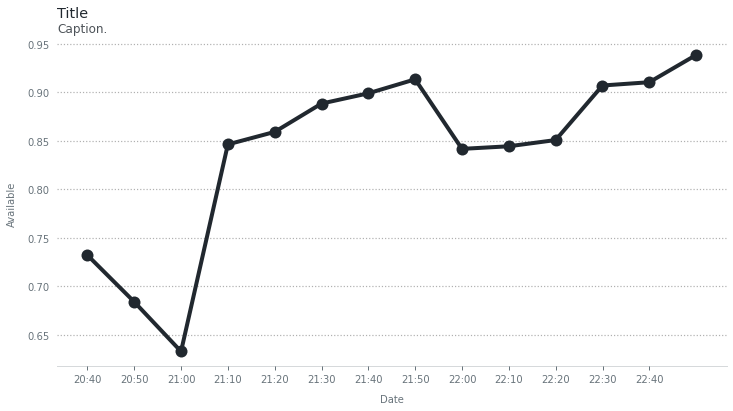

In [13]:
# create the visualization
figure = plt.figure(figsize=(12, 6))
viz = drawable.Drawable(figure)

# prepare the data
x = list(available.index)
y = list(available)

viz.draw_time_series(x, y, **style, **marker_style)

# finalize the visualization
viz.set_xlabel('Date')
viz.set_ylabel('Available')

# xticks = list(annotations)
xticks = list(range(int(min(x)) + 1, int(max(x)) + 1, 60 * 10))
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.fromtimestamp(x).strftime("%H:%M") for x in xticks ])
# viz.set_yticks([ ytick for ytick in viz.get_yticks() if ytick * 100 % 100 == 0 ])
viz.set_title("Title", loc='left')
viz.set_caption(f"""Caption.""",
                align='justify')

viz.show()
# viz.savefig('../exports/b-missing-tweets.png', dpi=300, bbox_inches='tight')

In [15]:
with open(os.path.expanduser(f"~/DATA/c5-evaluation/#LIVATM/ids-20211104.csv")) as f:
    id1 = [ tid.strip() for tid in f ]

with open(os.path.expanduser(f"~/DATA/c5-evaluation/#LIVATM/ids-20211105.csv")) as f:
    id2 = [ tid.strip() for tid in f ]

# kingkevii protected, cxmciii was not protected but is now

now = set(id2).difference(set(id1))
print(f"{ len(now) } IDs retrievable again from { len(df[df.id.isin(now)].groupby('screen_name')) } accounts")
df[df.id.isin(now)].groupby('screen_name').count().sort_values(by='id', ascending=False)['id'].head(20)

181 IDs retrievable again from 68 accounts


screen_name
Hafsa_1M           53
InnerSpeakerss     15
M_borlarjoko        6
weareJokerfc        6
FIairrr             6
hcjbjergx           5
ellieelouisee_x     5
iam_zyad            4
vsburna             4
baesileia           4
MrTekkersCook       3
cxmciii             3
roylzayn            3
ChiefYnwa           3
ilTheo              2
wellread_rina       2
postingdad          2
piwonskz            2
LFC_Arab_fans       2
ricflairdahvid      2
Name: id, dtype: int64